#**ML Group 18 Project - Predicting Percieved Health**
Group Members: Earlel Thiyagaratnam, Anthony McCreery, Alfredo Varelo Vega, Amirhossein Sabooni Asrehazer, Victoria Primeau

**Start by Reading in imports and Data**

In [ ]:
#All the imports necessary for the code:

from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [ ]:
#Within our submission we have provided the csv file with our data 'CVD_cleaned.csv' - please bring this into the colab repository to run the following:

cvd_data = pd.read_csv('CVD_cleaned.csv')
print(f"variables: {cvd_data.columns}")
print(f"Description of variables:\n {cvd_data.describe()}")
print(f"shape of data: {cvd_data.shape}")


variables: Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')
Description of variables:
          Height_(cm)    Weight_(kg)            BMI  Alcohol_Consumption  \
count  308854.000000  308854.000000  308854.000000        308854.000000   
mean      170.615249      83.588655      28.626211             5.096366   
std        10.658026      21.343210       6.522323             8.199763   
min        91.000000      24.950000      12.020000             0.000000   
25%       163.000000      68.040000      24.210000             0.000000   
50%       170.000000      81.650000      27.440000             1.000000   
75%       178.000000      95.250000      31.850000             6.0000

In [ ]:
cvd_data.dtypes

,0
General_Health,object
Checkup,object
Exercise,object
Heart_Disease,object
Skin_Cancer,object
Other_Cancer,object
Depression,object
Diabetes,object
Arthritis,object
Sex,object


# Data Pre-Processing

Now we will pre-process the data, luckily we have no missingness, so much of the work will involve converting data to the correct format, etc.

In [ ]:
#check column values with categorical data
cat_colnames = []
for col in cvd_data.columns:
    if cvd_data[col].dtype != 'float64':
        print(col)
        print(cvd_data[col].unique())
        cat_colnames.append(col)

#List the categorical columns with encodding required:
print(cat_colnames)

General_Health
['Poor' 'Very Good' 'Good' 'Fair' 'Excellent']
Checkup
['Within the past 2 years' 'Within the past year' '5 or more years ago'
 'Within the past 5 years' 'Never']
Exercise
['No' 'Yes']
Heart_Disease
['No' 'Yes']
Skin_Cancer
['No' 'Yes']
Other_Cancer
['No' 'Yes']
Depression
['No' 'Yes']
Diabetes
['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but female told only during pregnancy']
Arthritis
['Yes' 'No']
Sex
['Female' 'Male']
Age_Category
['70-74' '60-64' '75-79' '80+' '65-69' '50-54' '45-49' '18-24' '30-34'
 '55-59' '35-39' '40-44' '25-29']
Smoking_History
['Yes' 'No']
['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex', 'Age_Category', 'Smoking_History']


Note: in order for data to be reader friendly, convert outcome cat variables to:
Poor: 0
Fair: 1
Good: 2
Very Good: 3
Excellent: 4

In [ ]:
#Transforming data into category data type for dummy encoding
for col in cat_colnames:
    cvd_data[col] = cvd_data[col].astype("category")
print("Data types after transformation:")
print(cvd_data.dtypes)

# Define the ordered mapping for 'General_Health'
health_order_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Excellent': 4
}

#Now, transform 'General_Health' into ordered numerical values
cvd_data['General_Health'] = cvd_data['General_Health'].map(health_order_mapping)

#Check:
print(f"Transformed 'General_Health': {cvd_data['General_Health'].unique()}")
print(cvd_data['General_Health'].head())

Data types after transformation:
General_Health                  category
Checkup                         category
Exercise                        category
Heart_Disease                   category
Skin_Cancer                     category
Other_Cancer                    category
Depression                      category
Diabetes                        category
Arthritis                       category
Sex                             category
Age_Category                    category
Height_(cm)                      float64
Weight_(kg)                      float64
BMI                              float64
Smoking_History                 category
Alcohol_Consumption              float64
Fruit_Consumption                float64
Green_Vegetables_Consumption     float64
FriedPotato_Consumption          float64
dtype: object
Transformed 'General_Health': [0, 3, 2, 1, 4]
Categories (5, int64): [4, 1, 2, 0, 3]
0    0
1    3
2    3
3    0
4    2
Name: General_Health, dtype: category
Categories (5, i

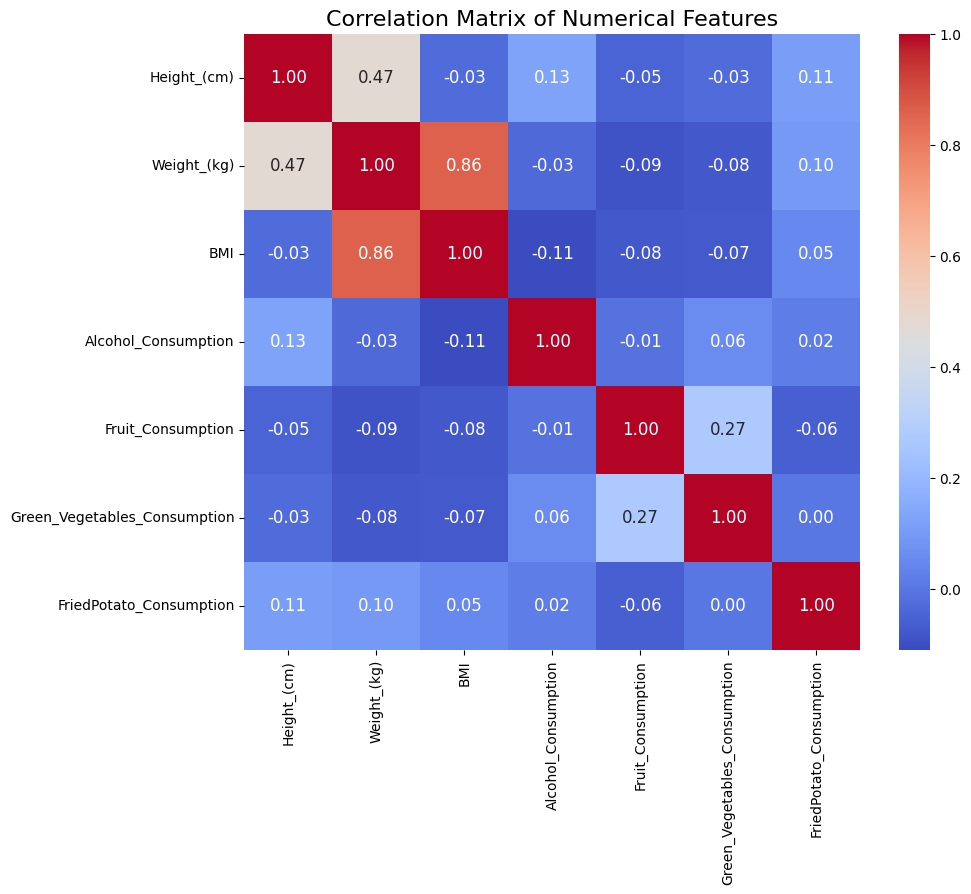

In [ ]:
#Perform correlation matrix to look to see if there are any correlated variables:

#Only the numerical columns
num_data = cvd_data.select_dtypes(include=['float64', 'int64'])
corr_matrix = num_data.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))  #frame the plot
sns.heatmap(corr_matrix,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            cbar=True,
            square=True,
            annot_kws={"size": 12})  #Make the test a bit larger
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [ ]:
#Drop BMI feature because correlated with BMI and don't want multicolinearity
cvd_data = cvd_data.drop(columns=['BMI'], errors='ignore')

Note: our outcome variable is entitled 'General Health' in the dataset, and the name may be a bit misleading, this is the subjective measure of a patients percieved health based on their own criteria.

In [ ]:
#Split the dataset into predictors and outcome (X and y)
x = cvd_data.loc[:, cvd_data.columns != "General_Health"]
y = cvd_data["General_Health"]

y.head()

,General_Health
0,0
1,3
2,3
3,0
4,2


Now, given the nature of 'percieved health reporting', we want to see the counts of the different classes of our outcome variable.

Why? To show that some groups are underrepresented, meaning we will have to think about ways to correctly predict for even underrepresented categories of the outcome variable.

In [ ]:
#Want to do a quick pivot table to check to see which categories of the outcome are overrepresented and underrepresented:
print("Unique values in 'General_Health' after mapping:", cvd_data['General_Health'].unique())

#Output Counts
print("\nValue counts in 'General_Health' after mapping:")
print(cvd_data['General_Health'].value_counts())

Unique values in 'General_Health' after mapping: [0, 3, 2, 1, 4]
Categories (5, int64): [4, 1, 2, 0, 3]

Value counts in 'General_Health' after mapping:
General_Health
3    110395
2     95364
4     55954
1     35810
0     11331
Name: count, dtype: int64


In this case, 0 represents the poor category, 1 fair, 2 good, etc. So we see that good is very representative, and poor/excellent are underrepresented in the data. We will have to try to find a way to account for this in the analysis (potentially by balancing weights to see if we get a better outcome.

# Split into Train/Val/Test

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = pd.DataFrame(y, columns=['general_health'])
y.head()
x = pd.get_dummies(x, drop_first=True)

In [ ]:
# Split data into train (70%), validation (15%), and test (15%), arbitrary random state =12 for everything just to set a seed:
Xtrain, Xtemp, ytrain, ytemp = train_test_split(x, y, test_size=0.3, random_state=12)
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, test_size=0.5, random_state=12)

#Shapes:
print("Training set shape:", Xtrain.shape, ytrain.shape)
print("Validation set shape:", Xval.shape, yval.shape)
print("Test set shape:", Xtest.shape, ytest.shape)

Training set shape: (216197, 33) (216197, 1)
Validation set shape: (46328, 33) (46328, 1)
Test set shape: (46329, 33) (46329, 1)


In [ ]:
Xtrain.head()

,Height_(cm),Weight_(kg),Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption,Checkup_Never,Checkup_Within the past 2 years,Checkup_Within the past 5 years,Checkup_Within the past year,...,Age_Category_40-44,Age_Category_45-49,Age_Category_50-54,Age_Category_55-59,Age_Category_60-64,Age_Category_65-69,Age_Category_70-74,Age_Category_75-79,Age_Category_80+,Smoking_History_Yes
244400,160.0,90.72,0.0,30.0,30.0,4.0,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
275964,168.0,63.50,2.0,60.0,8.0,10.0,False,False,False,True,...,True,False,False,False,False,False,False,False,False,True
57942,163.0,68.04,0.0,60.0,30.0,1.0,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
154873,152.0,63.50,0.0,12.0,2.0,3.0,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
107426,173.0,66.22,1.0,30.0,4.0,4.0,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
#Convert boolean to numeric to run regressions:
Xtrain = Xtrain.applymap(lambda x: 1 if x is True else (0 if x is False else x))

<ipython-input-13-410c1d830cca>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Xtrain = Xtrain.applymap(lambda x: 1 if x is True else (0 if x is False else x))


So in the data preprocessing step we have split into 70% training, 15% validation and 15% testing. We will use the training set to train, the validation set to compare model runs with different feature selection.

Our categorical variables are all treated as dummy variables and our binary outcome variables treated as such. Now let's pursue our first modelling effort:

# Model 1 - Multinomial Logistic Regression

**First Model to Test - Multinomial Regression**

Use the training data to train, then run predictions on the validation set.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Accuracy: 0.4256303278953917

Training Classification Report:
               precision    recall  f1-score   support

        Poor       0.41      0.05      0.10      7940
        Fair       0.38      0.13      0.20     25073
        Good       0.41      0.43      0.42     66590
   Very Good       0.43      0.70      0.54     77394
   Excellent       0.46      0.13      0.21     39200

    accuracy                           0.43    216197
   macro avg       0.42      0.29      0.29    216197
weighted avg       0.42      0.43      0.39    216197

Validation Accuracy: 0.4297401139699534

Validation Classification Report:
               precision    recall  f1-score   support

        Poor       0.41      0.05      0.09      1716
        Fair       0.37      0.14      0.20      5376
        Good       0.42      0.43      0.43     14430
   Very Good       0.44      0.71      0.54     16474
   Excellent       0.47      0.14      0.22      8332

    accuracy                         

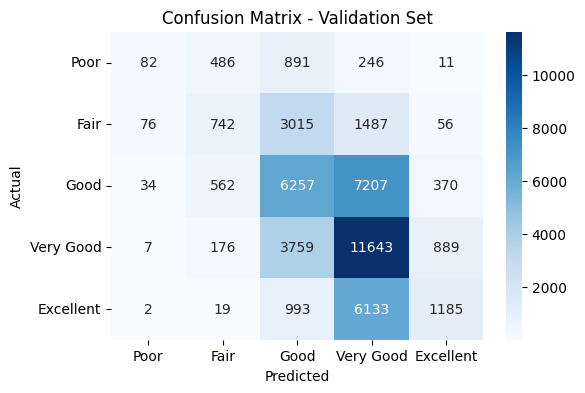

In [ ]:
#Create a pipeline for the logistic regression, include scaling for the numerical variables:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  #Scale features
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=0 #Just set random_state to 0 for the models
    ))
])

#Fit pipeline to training data
pipeline.fit(Xtrain, ytrain.values.ravel())

#Define the class labels:
class_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

#Evaluate on training set
ytrain_pred = pipeline.predict(Xtrain)
print("Training Accuracy:", accuracy_score(ytrain, ytrain_pred))
print("\nTraining Classification Report:\n", classification_report(ytrain, ytrain_pred, target_names=class_labels))

#Evaluate on val set
yval_pred = pipeline.predict(Xval)
print("Validation Accuracy:", accuracy_score(yval, yval_pred))
print("\nValidation Classification Report:\n", classification_report(yval, yval_pred, target_names=class_labels))

#Just do the confusion matris for the val set
conf_matrix_val = confusion_matrix(yval, yval_pred)

#Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Get the log-odds coefficients for the logistic regression model, this way we can interpret and comment on the result:

In [ ]:
#Get the logistic regression from the pipelines
logreg_pull = pipeline.named_steps['logreg']

# Get the feature names from the training data
feature_names = Xtrain.columns

# Get the coefficients and intercepts
coefficients = logreg_pull.coef_
intercepts = logreg_pull.intercept_

# Create a DataFrame for coefficients
coef_df = pd.DataFrame(coefficients.T, index=feature_names, columns=class_labels)

# Create a DataFrame for intercepts
intercept_df = pd.DataFrame(intercepts, index=class_labels, columns=["Intercept"])

# Combine coefficients and intercepts into a summary table
summary_df = pd.concat([coef_df, intercept_df.T], axis=0)

# Display the summary table
from IPython.display import display
display(summary_df)

,Poor,Fair,Good,Very Good,Excellent
Height_(cm),-0.146767,-0.209108,-0.103196,0.142658,0.316413
Weight_(kg),0.145007,0.255501,0.188319,-0.087730,-0.501097
Alcohol_Consumption,-0.190765,-0.108760,0.021571,0.134737,0.143217
Fruit_Consumption,-0.025527,-0.063091,-0.029782,0.023307,0.095093
Green_Vegetables_Consumption,-0.116231,-0.078596,-0.017298,0.049651,0.162474
FriedPotato_Consumption,0.044391,0.034967,0.025195,-0.022468,-0.082085
Checkup_Never,0.038053,-0.004120,-0.005528,-0.019948,-0.008457
Checkup_Within the past 2 years,-0.037080,-0.040935,0.024913,0.062069,-0.008968
Checkup_Within the past 5 years,-0.003632,-0.018830,0.017489,0.026152,-0.021180
Checkup_Within the past year,0.013402,-0.037507,0.017070,0.057460,-0.050425


How do we interpret the above:

Green_Vegetables_Consumption has a positive coefficient for "Excellent" (0.162474), therefore eating more green vegetables is associated with better perceived health.
Conversely, FriedPotato_Consumption has a negative coefficient for "Excellent" (-0.082085), so consuming fried potatoes might be linked to poorer health perceptions.

For Excercise, can plainly see:
Individuals who exercise are much less likely to have poor health compared to the baseline category.

Heart disease:
Poor health log likelihood is 0.304956 (Positive), therefore having heart disease significantly increases the likelihood of perceiving one's health as poor compared to the baseline.
Whereas excellent health log likelihood -0.292058 (Negative).... heart disease is strongly associated with a reduced likelihood of being in excellent health.

The majority of correctly classified cases fall under Good and Very Good, wwhich makes sense because these classes are overrepresented in our dataset or that the model is biased toward these labels. We need to find a way to misrepresnt less at the tails in future iterations of the model

So we can try to use balanced class weights to see what will happen - to have the model pay more attention to the underrepresented classes

Let's visualize the performance metrics now by plotting the actual data in the validation set vs the predictions.

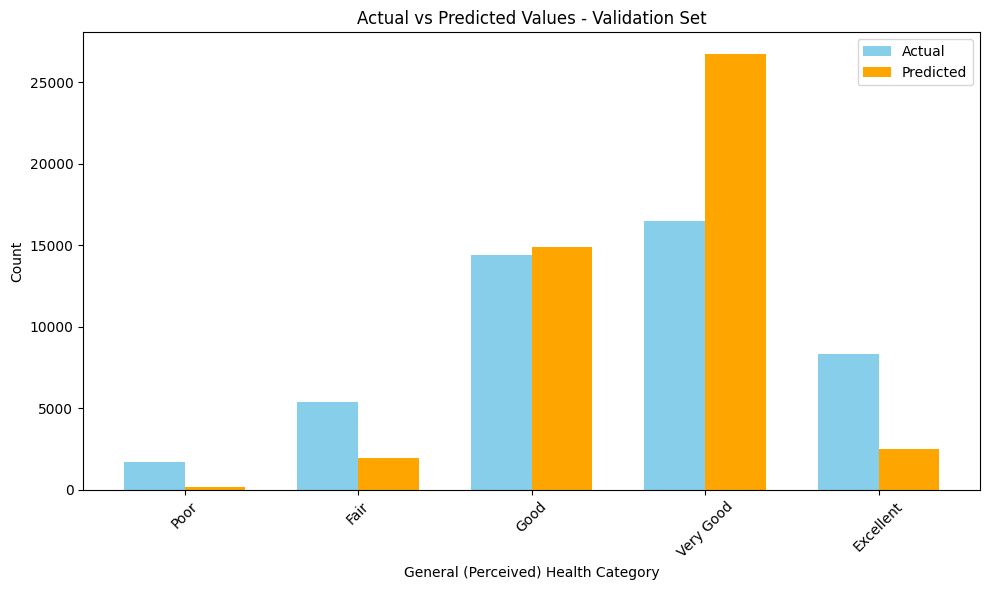

In [ ]:
#Now let's vizualize how good our predictions are, plot the actual counts vs predicted counts:
actual_counts = pd.Series(yval.values.ravel()).value_counts().sort_index()
predicted_counts = pd.Series(pipeline.predict(Xval)).value_counts().sort_index()

#Class labels:
class_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
actual_counts_aligned = [actual_counts.get(i, 0) for i in range(len(class_labels))]
predicted_counts_aligned = [predicted_counts.get(i, 0) for i in range(len(class_labels))]

#Plot:
x = np.arange(len(class_labels))  #X's
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, actual_counts_aligned, width, label='Actual', color='skyblue')
ax.bar(x + width/2, predicted_counts_aligned, width, label='Predicted', color='orange')
ax.set_xlabel('General (Perceived) Health Category')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Values - Validation Set')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

As we can see, our data is very good at predicting the 'Good' percieved health category... which makes sense... because this is the overrepresented. Let's now take a look if we can improve our predictions for Poor and Excellent by balancing weights.

# Model 2 - Multinomial Logistic Regression with Balanced Class Weights

Below we will run model 2, which includes the same procedure, but now for balanced weight classes.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Accuracy: 0.32690092832000445

Training Classification Report:
               precision    recall  f1-score   support

        Poor       0.15      0.61      0.25      7940
        Fair       0.22      0.24      0.23     25073
        Good       0.41      0.22      0.29     66590
   Very Good       0.45      0.25      0.32     77394
   Excellent       0.33      0.66      0.44     39200

    accuracy                           0.33    216197
   macro avg       0.31      0.40      0.30    216197
weighted avg       0.38      0.33      0.32    216197

Validation Accuracy: 0.3315921257123122

Validation Classification Report:
               precision    recall  f1-score   support

        Poor       0.16      0.63      0.26      1716
        Fair       0.22      0.23      0.23      5376
        Good       0.42      0.22      0.29     14430
   Very Good       0.47      0.25      0.33     16474
   Excellent       0.33      0.67      0.44      8332

    accuracy                        

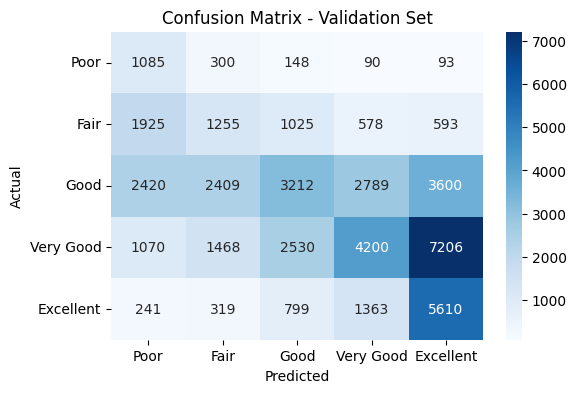

In [ ]:
#Create a pipeline for the logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  #Scale features again
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=0,
        class_weight='balanced'
    ))
])

#Fit pipeline to training data
pipeline.fit(Xtrain, ytrain.values.ravel())

#Evaluate on training set
ytrain_pred = pipeline.predict(Xtrain)
print("Training Accuracy:", accuracy_score(ytrain, ytrain_pred))
print("\nTraining Classification Report:\n", classification_report(ytrain, ytrain_pred, target_names=class_labels))

#Evaluate on val set
yval_pred = pipeline.predict(Xval)
print("Validation Accuracy:", accuracy_score(yval, yval_pred))
print("\nValidation Classification Report:\n", classification_report(yval, yval_pred, target_names=class_labels))

#Just do the confusion matris for the val set
conf_matrix_val = confusion_matrix(yval, yval_pred)

#Plot it
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#Get the model
logreg_pull = pipeline.named_steps['logreg']

#Get feature names:
feature_names = Xtrain.columns

#Get the coefficients and intercept
coefficients = logreg_pull.coef_
intercepts = logreg_pull.intercept_

#Create a df
coef_df = pd.DataFrame(coefficients.T, index=feature_names, columns=class_labels)

#Create df for intercepts
intercept_df = pd.DataFrame(intercepts, index=class_labels, columns=["Intercept"])

#Make a summary table:
summary_df = pd.concat([coef_df, intercept_df.T], axis=0)

#display
from IPython.display import display
display(summary_df)

,Poor,Fair,Good,Very Good,Excellent
Height_(cm),-0.134753,-0.190582,-0.096159,0.130851,0.290643
Weight_(kg),0.136253,0.230529,0.171916,-0.075997,-0.462700
Alcohol_Consumption,-0.192187,-0.107235,0.020690,0.133931,0.144802
Fruit_Consumption,-0.029121,-0.063964,-0.028846,0.025576,0.096356
Green_Vegetables_Consumption,-0.109874,-0.073804,-0.017716,0.045185,0.156209
FriedPotato_Consumption,0.049120,0.037531,0.023464,-0.025599,-0.084516
Checkup_Never,0.036184,-0.004625,-0.005079,-0.018940,-0.007540
Checkup_Within the past 2 years,-0.049840,-0.045734,0.029344,0.068864,-0.002634
Checkup_Within the past 5 years,-0.009386,-0.022246,0.019567,0.030129,-0.018065
Checkup_Within the past year,-0.001238,-0.040226,0.023254,0.064433,-0.046223


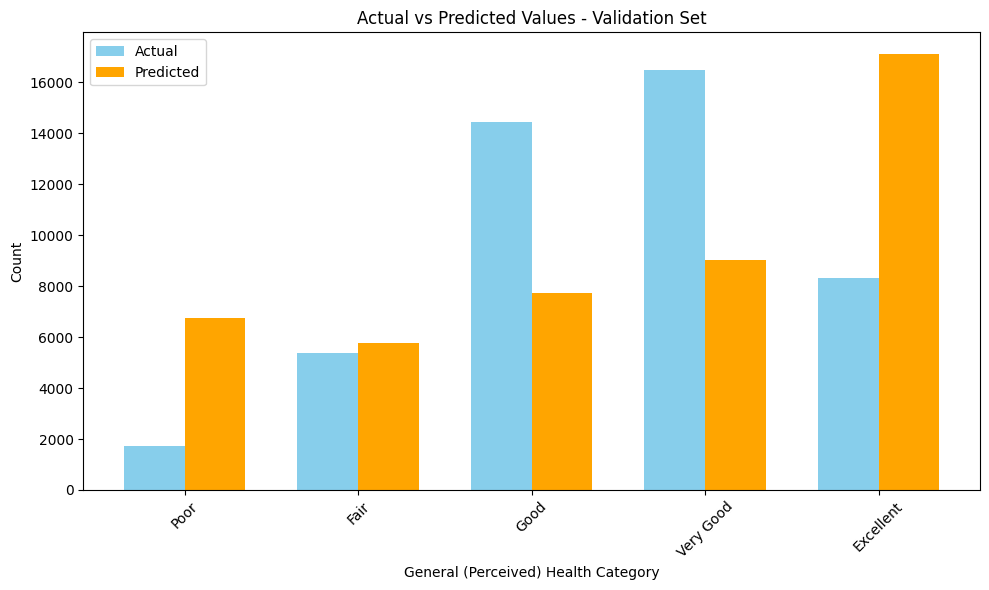

In [ ]:
#Now let's vizualize how good our predictions are, plot the actual counts vs predicted counts:
actual_counts = pd.Series(yval.values.ravel()).value_counts().sort_index()
predicted_counts = pd.Series(pipeline.predict(Xval)).value_counts().sort_index()

#Class labels:
class_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
actual_counts_aligned = [actual_counts.get(i, 0) for i in range(len(class_labels))]
predicted_counts_aligned = [predicted_counts.get(i, 0) for i in range(len(class_labels))]

#Plot:
x = np.arange(len(class_labels))  #X's
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, actual_counts_aligned, width, label='Actual', color='skyblue')
ax.bar(x + width/2, predicted_counts_aligned, width, label='Predicted', color='orange')
ax.set_xlabel('General (Perceived) Health Category')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Values - Validation Set')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

So now with balanced weights we have the opposite problem... we are now predicting poor and excellent too much and good/very good not enough... but we are quite good at predicting fair. Let's look at feature importance:

**Feature Importance:**

Based on the regression run, let's evaluate the top features:

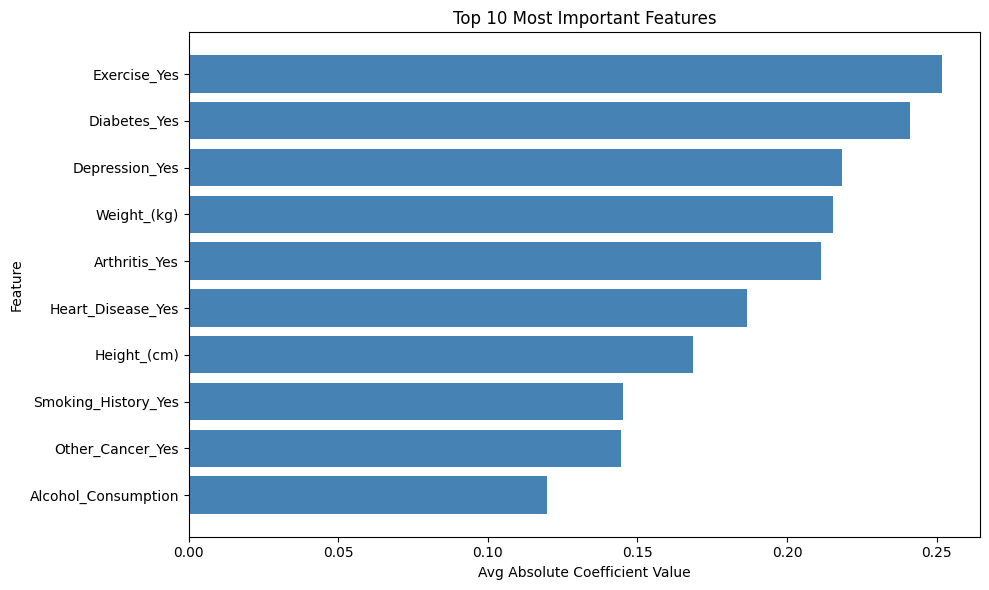

In [ ]:
#Extract mean and abs dev coefficients
coef_mean_abs = np.mean(np.abs(coefficients), axis=0)

#Make a df with important features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Avg Absolute Coefficient Value': coef_mean_abs
})

#sort and get top 10
top_features = feature_importance_df.sort_values(by='Avg Absolute Coefficient Value', ascending=False).head(10)

#Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Avg Absolute Coefficient Value'], color='steelblue')
plt.xlabel('Avg Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

These feature importance values should be taken with a grain of salt - they are determined by the avg absolute coefficient value but we are looking at an outcome variable across many classes.

That said, the top features in terms of feature importance make sense - with exercise and diabetes being large contributers, and other categorical variables like age, etc. don't provide much explanatory power. We see that very few consumption variables make the top 10 list in terms of feature importance. We attempted taking these features out but the validation accuracy does not improve much.

**On the test set:**

Now, after attampts at feature selection, we were not able to find a selection or construction that gives a better validation f1 score or accuracy, let's get the performance metrics on the out-of-sample test data and in this way we can compare with our other subsequent ML models.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.32564916143236416

Test Classification Report:
               precision    recall  f1-score   support

        Poor       0.15      0.61      0.24      1675
        Fair       0.23      0.24      0.23      5361
        Good       0.41      0.22      0.28     14344
   Very Good       0.45      0.25      0.32     16527
   Excellent       0.33      0.66      0.44      8422

    accuracy                           0.33     46329
   macro avg       0.31      0.40      0.30     46329
weighted avg       0.38      0.33      0.32     46329



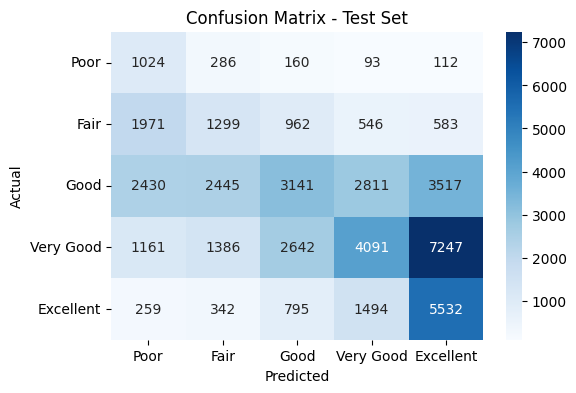


Logistic Regression Coefficients and Intercepts (Test Set):


,Poor,Fair,Good,Very Good,Excellent
Height_(cm),-0.134753,-0.190582,-0.096159,0.130851,0.290643
Weight_(kg),0.136253,0.230529,0.171916,-0.075997,-0.462700
Alcohol_Consumption,-0.192187,-0.107235,0.020690,0.133931,0.144802
Fruit_Consumption,-0.029121,-0.063964,-0.028846,0.025576,0.096356
Green_Vegetables_Consumption,-0.109874,-0.073804,-0.017716,0.045185,0.156209
FriedPotato_Consumption,0.049120,0.037531,0.023464,-0.025599,-0.084516
Checkup_Never,0.036184,-0.004625,-0.005079,-0.018940,-0.007540
Checkup_Within the past 2 years,-0.049840,-0.045734,0.029344,0.068864,-0.002634
Checkup_Within the past 5 years,-0.009386,-0.022246,0.019567,0.030129,-0.018065
Checkup_Within the past year,-0.001238,-0.040226,0.023254,0.064433,-0.046223


In [ ]:
#Create a pipeline for logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=0,
        class_weight='balanced'
    ))
])

#Fit pipeline to training data
pipeline.fit(Xtrain, ytrain.values.ravel())

#On the test set
ytest_pred = pipeline.predict(Xtest)
print("Test Accuracy:", accuracy_score(ytest, ytest_pred))

#Get the classification report
print("\nTest Classification Report:\n", classification_report(ytest, ytest_pred, target_names=class_labels))

#Confusion matrix:
conf_matrix_test = confusion_matrix(ytest, ytest_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Extract coefficients and intercepts from the logistic regression model
logreg_pull = pipeline.named_steps['logreg']
coefficients = logreg_pull.coef_
intercepts = logreg_pull.intercept_

#Create dataframe
coef_df = pd.DataFrame(coefficients.T, index=Xtest.columns, columns=class_labels)
intercept_df = pd.DataFrame(intercepts, index=class_labels, columns=["Intercept"])

#Summary Table
summary_df = pd.concat([coef_df, intercept_df.T], axis=0)

#Display:
from IPython.display import display
print("\nLogistic Regression Coefficients and Intercepts (Test Set):")
display(summary_df)

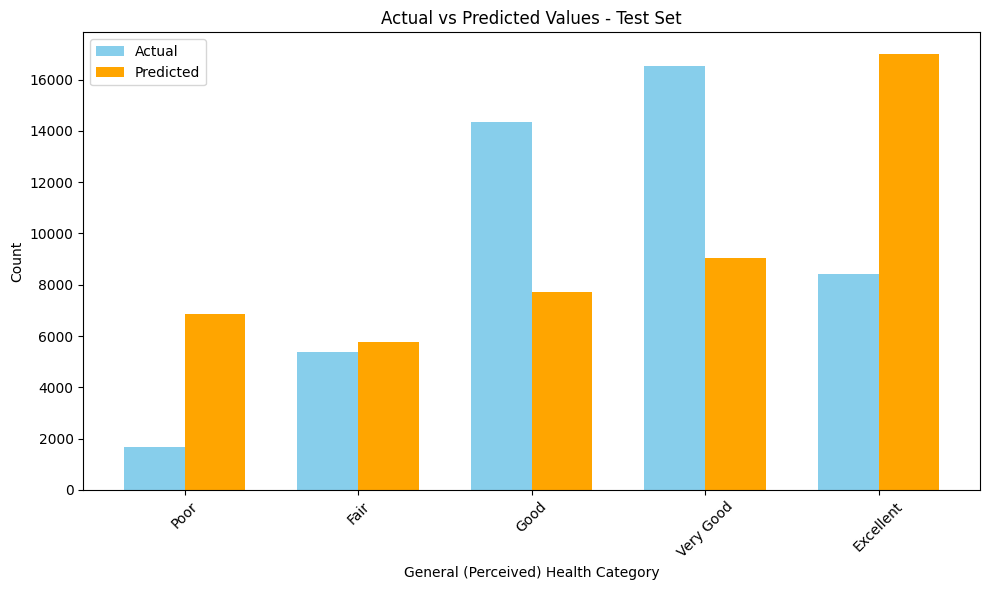

In [ ]:
#Now let's visualize how good our predictions are for the test set
actual_counts = pd.Series(ytest.values.ravel()).value_counts().sort_index()
predicted_counts = pd.Series(pipeline.predict(Xtest)).value_counts().sort_index()

#Class labels:
class_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
actual_counts_aligned = [actual_counts.get(i, 0) for i in range(len(class_labels))]
predicted_counts_aligned = [predicted_counts.get(i, 0) for i in range(len(class_labels))]

#Plot:
x = np.arange(len(class_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, actual_counts_aligned, width, label='Actual', color='skyblue')
ax.bar(x + width/2, predicted_counts_aligned, width, label='Predicted', color='orange')
ax.set_xlabel('General (Perceived) Health Category')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Values - Test Set')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Model 3 - Random Forest

We've had some success with our first two models in predicting percieved health.

Run a random forest and see how the test results compare to above for the multinomial logistic regression

Training Accuracy: 0.43

Classification Report (Training):
               precision    recall  f1-score   support

        Poor       0.34      0.86      0.48      7940
        Fair       0.38      0.57      0.46     25073
        Good       0.56      0.33      0.41     66590
   Very Good       0.56      0.29      0.38     77394
   Excellent       0.35      0.71      0.47     39200

    accuracy                           0.43    216197
   macro avg       0.44      0.55      0.44    216197
weighted avg       0.49      0.43      0.42    216197

Test Accuracy: 0.34

Classification Report (Test):
               precision    recall  f1-score   support

        Poor       0.18      0.47      0.26      1675
        Fair       0.24      0.36      0.29      5361
        Good       0.41      0.24      0.30     14344
   Very Good       0.45      0.24      0.31     16527
   Excellent       0.33      0.65      0.43      8422

    accuracy                           0.34     46329
   macro avg       

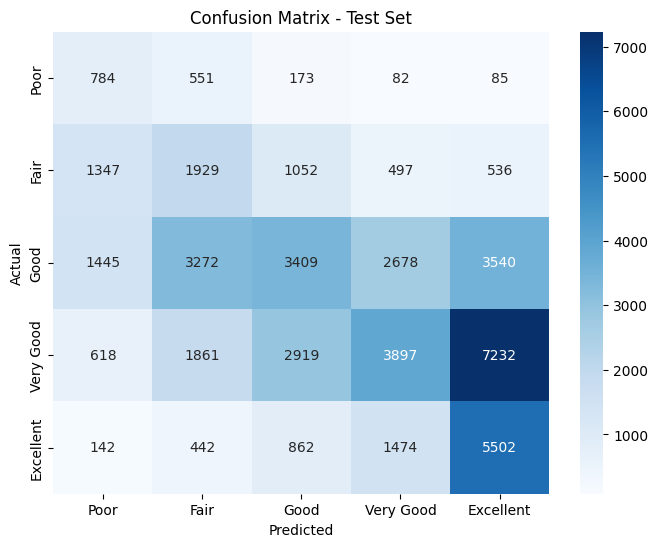

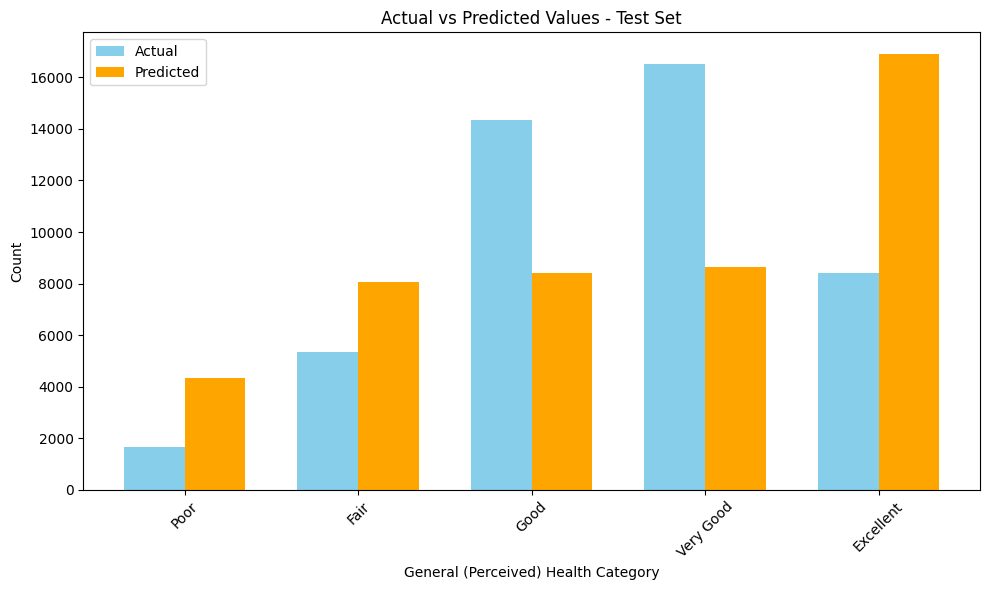

In [ ]:
#Define labels
class_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

#Pipeline for the RF:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),  #include scaling
    ('rf', RandomForestClassifier(
        n_estimators=100,
        random_state=12,
        class_weight='balanced',
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5
    ))
])

#fit pipeline to the training data
pipeline_rf.fit(Xtrain, ytrain.values.ravel())

#Evaluate training set
ytrain_pred = pipeline_rf.predict(Xtrain)
train_accuracy = accuracy_score(ytrain, ytrain_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"\nClassification Report (Training):\n", classification_report(ytrain, ytrain_pred, target_names=class_labels))

#Predict on test set
ytest_pred = pipeline_rf.predict(Xtest)
test_accuracy = accuracy_score(ytest, ytest_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"\nClassification Report (Test):\n", classification_report(ytest, ytest_pred, target_names=class_labels))

#Confusion Matrix for test set
conf_matrix = confusion_matrix(ytest, ytest_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Actual vs Predicted for the test set
actual_counts = pd.Series(ytest.values.ravel()).value_counts().sort_index()
predicted_counts = pd.Series(ytest_pred).value_counts().sort_index()

actual_counts_aligned = [actual_counts.get(i, 0) for i in range(len(class_labels))]
predicted_counts_aligned = [predicted_counts.get(i, 0) for i in range(len(class_labels))]

#Plot Actual vs Predicted
x = np.arange(len(class_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, actual_counts_aligned, width, label='Actual', color='skyblue')
ax.bar(x + width/2, predicted_counts_aligned, width, label='Predicted', color='orange')
ax.set_xlabel('General (Perceived) Health Category')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Values - Test Set')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

The random forest actually produces similar results, we are still balancing weights,

let's attempt a neural net where we will not perform class balancing, to see the results:

# Model 4 - Neural Network

Without balancing weights. After some parameter tuning, the resulting hidden layers used will be 10,10,5,2:



Training Accuracy: 0.43

Classification Report (Training):
               precision    recall  f1-score   support

        Poor       0.44      0.06      0.11      7940
        Fair       0.38      0.15      0.22     25073
        Good       0.41      0.46      0.44     66590
   Very Good       0.44      0.67      0.53     77394
   Excellent       0.48      0.17      0.25     39200

    accuracy                           0.43    216197
   macro avg       0.43      0.30      0.31    216197
weighted avg       0.43      0.43      0.40    216197

Test Accuracy: 0.43

Classification Report (Test):
               precision    recall  f1-score   support

        Poor       0.39      0.06      0.10      1675
        Fair       0.37      0.15      0.22      5361
        Good       0.41      0.46      0.43     14344
   Very Good       0.44      0.66      0.53     16527
   Excellent       0.47      0.17      0.25      8422

    accuracy                           0.43     46329
   macro avg       

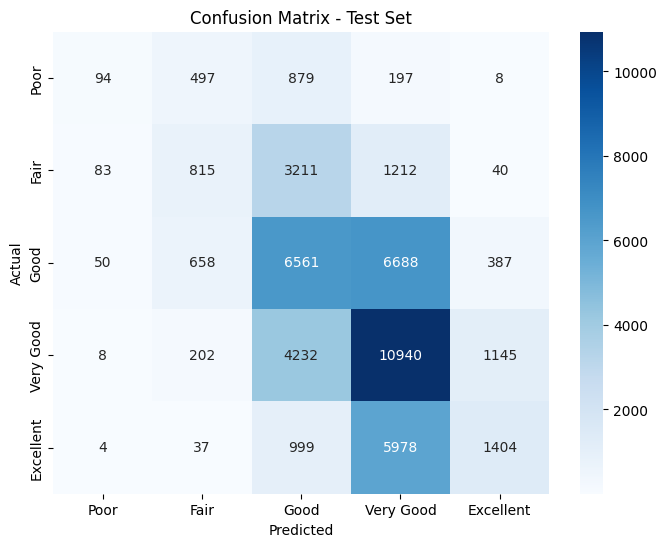

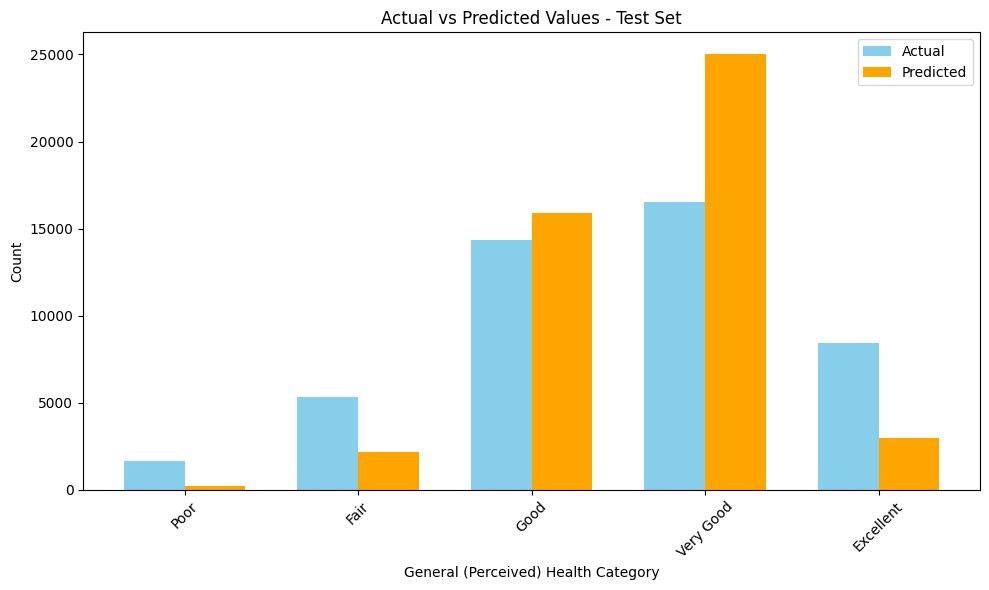

In [ ]:
# Define labels
class_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']

#Pipeline for neuralnet
pipeline_nn = Pipeline([
    ('scaler', StandardScaler()),  #Still need to perform scaling
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(10, 10, 5, 2), #hidden layers landed upon after some parameter tuning.
        max_iter=300,
        activation='relu',
        solver='adam',
        random_state=12
    ))
])

#Fit pipeline:
pipeline_nn.fit(Xtrain, ytrain.values.ravel())

#Evlautate training
ytrain_pred = pipeline_nn.predict(Xtrain)
train_accuracy = accuracy_score(ytrain, ytrain_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"\nClassification Report (Training):\n", classification_report(ytrain, ytrain_pred, target_names=class_labels))

#Now testing
ytest_pred = pipeline_nn.predict(Xtest)
test_accuracy = accuracy_score(ytest, ytest_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"\nClassification Report (Test):\n", classification_report(ytest, ytest_pred, target_names=class_labels))

#Confusion matrix
conf_matrix = confusion_matrix(ytest, ytest_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#actual vs predicted
actual_counts = pd.Series(ytest.values.ravel()).value_counts().sort_index()
predicted_counts = pd.Series(ytest_pred).value_counts().sort_index()

actual_counts_aligned = [actual_counts.get(i, 0) for i in range(len(class_labels))]
predicted_counts_aligned = [predicted_counts.get(i, 0) for i in range(len(class_labels))]

#Plot
x = np.arange(len(class_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, actual_counts_aligned, width, label='Actual', color='skyblue')
ax.bar(x + width/2, predicted_counts_aligned, width, label='Predicted', color='orange')
ax.set_xlabel('General (Perceived) Health Category')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Values - Test Set')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


The results, while a bit better than the multinomial logistic regression without balanced classes... is still not sufficiently accounting for the discrepancy in underrepresented classes. Based on the coefficient similarity between Poor and Fair, as well as Very Good and Excellent, and given that these groups should be considered in a similar manner, we will consolidate these classes in order to improve predictive accuracy while still limiting loss of interpretability.

# Consolidating Poor/Fair & Very Good/Excellent

Within this section we will do the same data processing as before, but we will consolidate the poor/fair classes as well as the very good/excellent classes:

In [ ]:
cvd_data = pd.read_csv('CVD_cleaned.csv')
print(f"variables: {cvd_data.columns}")
print(f"Description of variables:\n {cvd_data.describe()}")
print(f"shape of data: {cvd_data.shape}")

#check column values with categorical data
cat_colnames = []
for col in cvd_data.columns:
    if cvd_data[col].dtype != 'float64':
        print(col)
        print(cvd_data[col].unique())
        cat_colnames.append(col)

# list with categorical columns with encoding needed
print(cat_colnames)

#Transforming data into category data type for dummy encoding
for col in cat_colnames:
    cvd_data[col] = cvd_data[col].astype("category")
print("Data types after transformation:")
print(cvd_data.dtypes)

# Define the ordered mapping for 'General_Health'
health_order_mapping = {
    'Poor': 0,
    'Fair': 0,
    'Good': 1,
    'Very Good': 2,
    'Excellent': 2
}

# Map and transform
cvd_data['General_Health'] = cvd_data['General_Health'].map(health_order_mapping)



#Drop Weight feature because correlated with BMI and don't want multicolinearity
cvd_data = cvd_data.drop(columns=['Weight_(kg)'], errors='ignore')

# Split the dataset into X and y
x = cvd_data.loc[:, cvd_data.columns != "General_Health"]
y = cvd_data["General_Health"]

y.head()

#Check pivot:
print("Unique values in 'General_Health' after mapping:", cvd_data['General_Health'].unique())

#View Pivot:
print("\nValue counts in 'General_Health' after mapping:")
print(cvd_data['General_Health'].value_counts())


variables: Index(['General_Health', 'Checkup', 'Exercise', 'Heart_Disease', 'Skin_Cancer',
       'Other_Cancer', 'Depression', 'Diabetes', 'Arthritis', 'Sex',
       'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Smoking_History',
       'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption'],
      dtype='object')
Description of variables:
          Height_(cm)    Weight_(kg)            BMI  Alcohol_Consumption  \
count  308854.000000  308854.000000  308854.000000        308854.000000   
mean      170.615249      83.588655      28.626211             5.096366   
std        10.658026      21.343210       6.522323             8.199763   
min        91.000000      24.950000      12.020000             0.000000   
25%       163.000000      68.040000      24.210000             0.000000   
50%       170.000000      81.650000      27.440000             1.000000   
75%       178.000000      95.250000      31.850000             6.0000

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = pd.DataFrame(y, columns=['general_health'])
y.head()
x = pd.get_dummies(x, drop_first=True)

# Split data into train (70%), validation (15%), and test (15%)
Xtrain, Xtemp, ytrain, ytemp = train_test_split(x, y, test_size=0.3, random_state=12)
Xval, Xtest, yval, ytest = train_test_split(Xtemp, ytemp, test_size=0.5, random_state=12)

# Display the shapes of the resulting splits
print("Training set shape:", Xtrain.shape, ytrain.shape)
print("Validation set shape:", Xval.shape, yval.shape)
print("Test set shape:", Xtest.shape, ytest.shape)

#Conver boolean to numeric to run regressions:
Xtrain = Xtrain.applymap(lambda x: 1 if x is True else (0 if x is False else x))

Training set shape: (216197, 33) (216197, 1)
Validation set shape: (46328, 33) (46328, 1)
Test set shape: (46329, 33) (46329, 1)


<ipython-input-27-03f1ece49a69>:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Xtrain = Xtrain.applymap(lambda x: 1 if x is True else (0 if x is False else x))


# Model 5 - Multinomial Logistic Regression with Balanced Class Weights and with Consolidated Categories

Ultimately, as a mitigation effort to allow for more predictive accuracy, a rational next step is to combine classes when it makes intuitive sense. In other words, consolidate outcome classes to combine the ‘Poor’ and ‘Fair’ Categories as well as the ‘Very Good’ and ‘Excellent’ categories. When we make this additional adjustment with balanced class weights - this works for our project as we are more interested in differentiating between those who are not good, vs just goo vs very good.... so we can consolidate at the low and high ends

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Accuracy: 0.5609328529073021

Training Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.63      0.47     33013
           1       0.40      0.29      0.34     66590
           2       0.72      0.70      0.71    116594

    accuracy                           0.56    216197
   macro avg       0.50      0.54      0.50    216197
weighted avg       0.57      0.56      0.56    216197

Test Accuracy: 0.5609229640182175

Test Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.63      0.47      7036
           1       0.40      0.29      0.34     14344
           2       0.72      0.70      0.71     24949

    accuracy                           0.56     46329
   macro avg       0.50      0.54      0.50     46329
weighted avg       0.57      0.56      0.56     46329



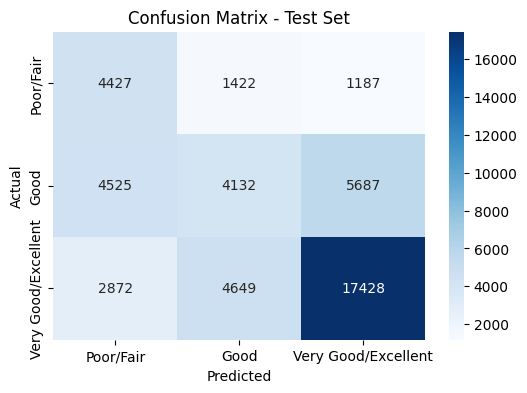

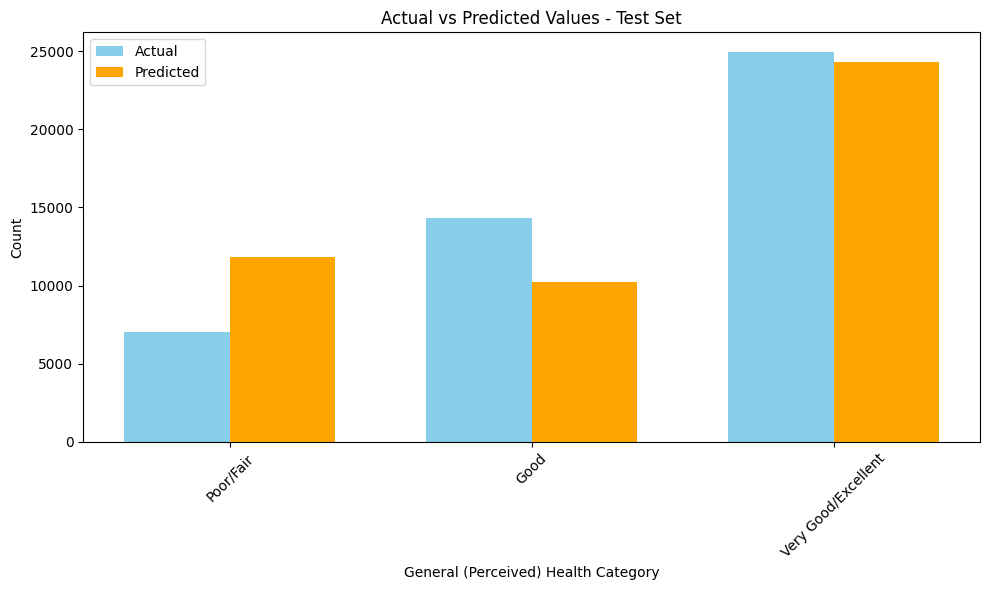

In [ ]:
#Pipeline - now with the consolidated classes.
#Note the code is pretty much the same, the only difference is the
pipeline_reg_consol = Pipeline([
    ('scaler', StandardScaler()),  #with scaling
    ('logreg', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=0,
        class_weight='balanced'
    ))
])

#Fit pipeline
pipeline_reg_consol.fit(Xtrain, ytrain.values.ravel())

#Train accuracy
ytrain_pred = pipeline_reg_consol.predict(Xtrain)
print("Training Accuracy:", accuracy_score(ytrain, ytrain_pred))
print("\nTraining Classification Report:\n", classification_report(ytrain, ytrain_pred))

#Test accuracy
ytest_pred = pipeline_reg_consol.predict(Xtest)
print("Test Accuracy:", accuracy_score(ytest, ytest_pred))

#Classification report:
print("\nTest Classification Report:\n", classification_report(ytest, ytest_pred))

#Conf matrix
conf_matrix_test = confusion_matrix(ytest, ytest_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor/Fair', 'Good', 'Very Good/Excellent'], yticklabels=['Poor/Fair', 'Good', 'Very Good/Excellent'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Visualize how good our predictions are for the test set
actual_counts = pd.Series(ytest.values.ravel()).value_counts().sort_index()
predicted_counts = pd.Series(ytest_pred).value_counts().sort_index()

#Now get the count plot
class_labels = ['Poor/Fair', 'Good', 'Very Good/Excellent']
actual_counts_aligned = [actual_counts.get(i, 0) for i in range(len(class_labels))]
predicted_counts_aligned = [predicted_counts.get(i, 0) for i in range(len(class_labels))]

#Plot
x = np.arange(len(class_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, actual_counts_aligned, width, label='Actual', color='skyblue')
ax.bar(x + width/2, predicted_counts_aligned, width, label='Predicted', color='orange')
ax.set_xlabel('General (Perceived) Health Category')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Values - Test Set')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Get te coefficients in the same way as before:


#Extract coefficients and intercepts from the logistic regression model
logreg_pull = pipeline.named_steps['logreg']
coefficients = logreg_pull.coef_
intercepts = logreg_pull.intercept_

#Create dataframe
coef_df = pd.DataFrame(coefficients.T, index=Xtest.columns, columns=class_labels)
intercept_df = pd.DataFrame(intercepts, index=class_labels, columns=["Intercept"])

#Summary Table
summary_df = pd.concat([coef_df, intercept_df.T], axis=0)

#Display:
from IPython.display import display
print("\nLogistic Regression Coefficients and Intercepts (Test Set):")
display(summary_df)


Logistic Regression Coefficients and Intercepts (Test Set):


,Poor/Fair,Good,Very Good/Excellent
Height_(cm),-0.082101,-0.013171,0.095272
BMI,0.139061,0.100049,-0.239111
Alcohol_Consumption,-0.134515,0.009676,0.124839
Fruit_Consumption,-0.044825,-0.016985,0.061811
Green_Vegetables_Consumption,-0.075040,-0.011657,0.086697
FriedPotato_Consumption,0.033614,0.018697,-0.052311
Checkup_Never,0.011009,-0.000189,-0.010820
Checkup_Within the past 2 years,-0.050268,0.019137,0.031131
Checkup_Within the past 5 years,-0.021020,0.014581,0.006438
Checkup_Within the past year,-0.036172,0.016738,0.019434


We can see that the general trends we referenced before still hold. This is a positive sign because it shows that we don't lose our interpretability when we consolidate classes, but we can produce better predictive accuracy. Let's continue and look at the consolidated classes and how the random forest performs:

# Model 6 - Random Forest with Consolidated Categories

Training Accuracy: 0.63

Classification Report (Training):
                      precision    recall  f1-score   support

          Poor/Fair       0.48      0.73      0.57     33013
               Good       0.51      0.44      0.47     66590
Very Good/Excellent       0.75      0.70      0.73    116594

           accuracy                           0.63    216197
          macro avg       0.58      0.62      0.59    216197
       weighted avg       0.64      0.63      0.63    216197

Test Accuracy: 0.56

Classification Report (Test):
                      precision    recall  f1-score   support

          Poor/Fair       0.39      0.61      0.48      7036
               Good       0.41      0.34      0.37     14344
Very Good/Excellent       0.73      0.68      0.70     24949

           accuracy                           0.56     46329
          macro avg       0.51      0.54      0.52     46329
       weighted avg       0.58      0.56      0.57     46329



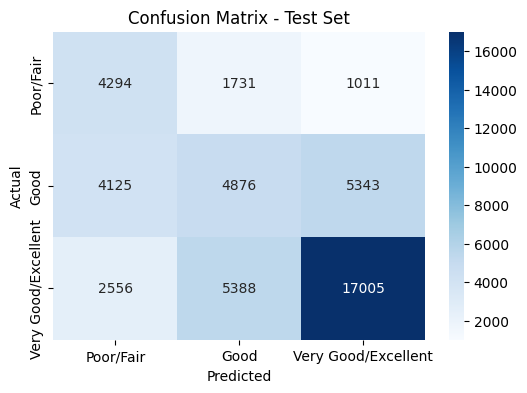

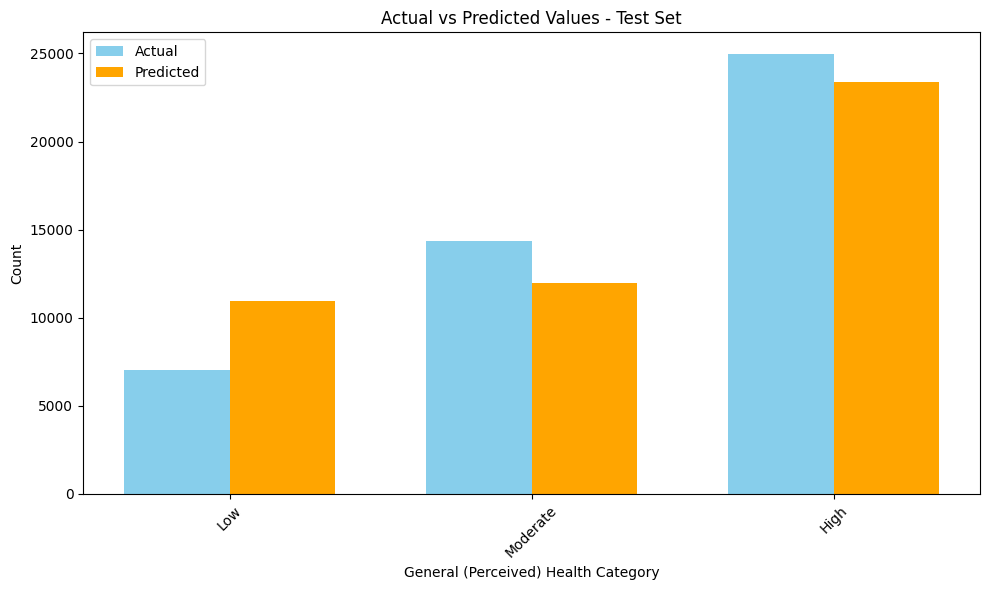

In [ ]:
#Random forest pipeline
pipeline_cons_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        random_state=12,
        class_weight='balanced',
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5
    ))
])

#fit pipe
pipeline_cons_rf.fit(Xtrain, ytrain.values.ravel())

#Training predictions
ytrain_pred = pipeline_cons_rf.predict(Xtrain)
train_accuracy = accuracy_score(ytrain, ytrain_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"\nClassification Report (Training):\n", classification_report(ytrain, ytrain_pred, target_names=['Poor/Fair', 'Good', 'Very Good/Excellent']))

#Test predictions
ytest_pred = pipeline_cons_rf.predict(Xtest)
test_accuracy = accuracy_score(ytest, ytest_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"\nClassification Report (Test):\n", classification_report(ytest, ytest_pred, target_names=['Poor/Fair', 'Good', 'Very Good/Excellent']))

#Confusion matrix for the test set
conf_matrix_test = confusion_matrix(ytest, ytest_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor/Fair', 'Good', 'Very Good/Excellent'], yticklabels=['Poor/Fair', 'Good', 'Very Good/Excellent'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Now let's visualize how good our predictions are for the test set
actual_counts = pd.Series(ytest.values.ravel()).value_counts().sort_index()
predicted_counts = pd.Series(ytest_pred).value_counts().sort_index()

#.... same as before
class_labels = ['Low', 'Moderate', 'High']
actual_counts_aligned = [actual_counts.get(i, 0) for i in range(len(class_labels))]
predicted_counts_aligned = [predicted_counts.get(i, 0) for i in range(len(class_labels))]

# Plot:::
x = np.arange(len(class_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, actual_counts_aligned, width, label='Actual', color='skyblue')
ax.bar(x + width/2, predicted_counts_aligned, width, label='Predicted', color='orange')
ax.set_xlabel('General (Perceived) Health Category')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Values - Test Set')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Model 7 - Neural Network with Consolidated Categories:

Training Accuracy: 0.61

Classification Report (Training):
                      precision    recall  f1-score   support

          Poor/Fair       0.54      0.37      0.44     33013
               Good       0.44      0.28      0.34     66590
Very Good/Excellent       0.66      0.86      0.75    116594

           accuracy                           0.61    216197
          macro avg       0.55      0.50      0.51    216197
       weighted avg       0.57      0.61      0.58    216197

Test Accuracy: 0.60

Classification Report (Test):
                      precision    recall  f1-score   support

          Poor/Fair       0.52      0.37      0.43      7036
               Good       0.43      0.27      0.33     14344
Very Good/Excellent       0.66      0.86      0.75     24949

           accuracy                           0.60     46329
          macro avg       0.54      0.50      0.50     46329
       weighted avg       0.57      0.60      0.57     46329



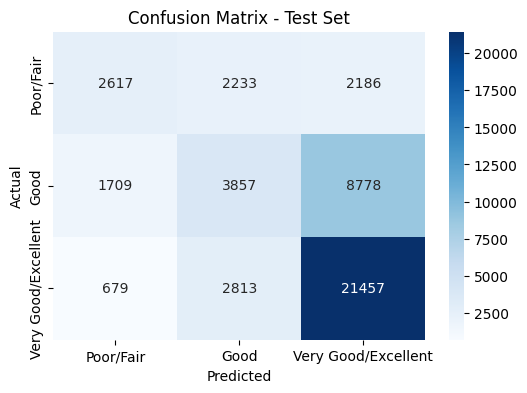

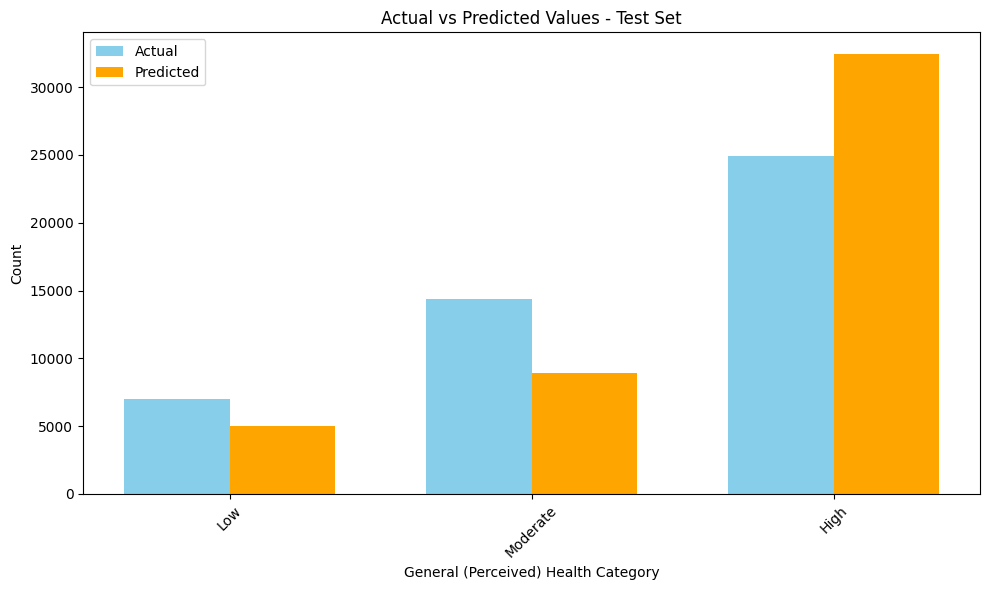

In [ ]:
#Neural net pipeline
pipeline_cons_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(10, 10, 5, 2),
        max_iter=300,
        activation='relu',
        solver='adam',
        random_state=12
    ))
])

#Fit pipeline
pipeline_cons_nn.fit(Xtrain, ytrain.values.ravel())

#Training predict
ytrain_pred = pipeline_cons_nn.predict(Xtrain)
train_accuracy = accuracy_score(ytrain, ytrain_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"\nClassification Report (Training):\n", classification_report(ytrain, ytrain_pred, target_names=['Poor/Fair', 'Good', 'Very Good/Excellent']))

#out-of-sample predict
ytest_pred = pipeline_cons_nn.predict(Xtest)
test_accuracy = accuracy_score(ytest, ytest_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"\nClassification Report (Test):\n", classification_report(ytest, ytest_pred, target_names=['Poor/Fair', 'Good', 'Very Good/Excellent']))

#Conf matrix
conf_matrix_test = confusion_matrix(ytest, ytest_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor/Fair', 'Good', 'Very Good/Excellent'], yticklabels=['Poor/Fair', 'Good', 'Very Good/Excellent'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Now let's visualize how good our predictions are for the test set
actual_counts = pd.Series(ytest.values.ravel()).value_counts().sort_index()
predicted_counts = pd.Series(ytest_pred).value_counts().sort_index()

# Align counts with class labels
class_labels = ['Low', 'Moderate', 'High']
actual_counts_aligned = [actual_counts.get(i, 0) for i in range(len(class_labels))]
predicted_counts_aligned = [predicted_counts.get(i, 0) for i in range(len(class_labels))]

#Plot
x = np.arange(len(class_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, actual_counts_aligned, width, label='Actual', color='skyblue')
ax.bar(x + width/2, predicted_counts_aligned, width, label='Predicted', color='orange')
ax.set_xlabel('General (Perceived) Health Category')
ax.set_ylabel('Count')
ax.set_title('Actual vs Predicted Values - Test Set')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

As you can plainly see, when consolidating classes, we have much less underrepresentation for the poor and excellent categories...

When we do this, we are much better at predicting poor and fair together in a bundle, based on our supposition and based on our coefficient table for 5 categories, it makes rational sense to consider these as a group together

The neural net with consolidated classes becomes our best model, with the highest overall predictive accuracy on out-of-sample (test) data

**Visualize MLP final architecture**

Documented steps for how to produce these vizualizations:
1. Go to the following github: https://github.com/jzliu-100/visualize-neural-network

2. Download the file 'VizualizeNN.py' and bring it into the repository

3. Pip install using the below code

4. Run the below code.

In [ ]:
!pip install palettable

MLPClassifier(hidden_layer_sizes=(10, 10, 5, 2), max_iter=300, random_state=12)


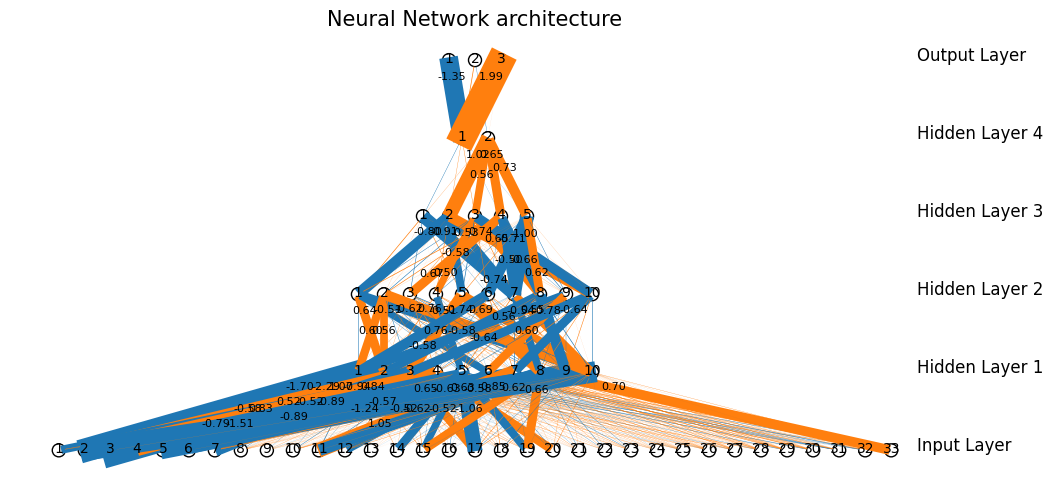

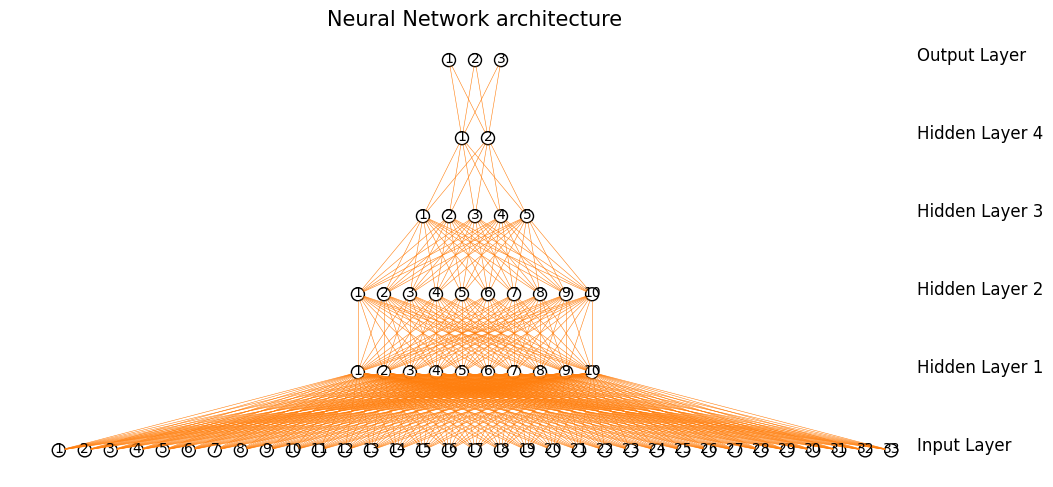

In [ ]:

import VisualizeNN as VisNN

mlp_model = pipeline_cons_nn["mlp"]
print(mlp_model)
weights= mlp_model.coefs_
network_structure = np.hstack(([Xtrain.shape[1]], np.asarray(mlp_model.hidden_layer_sizes), 3))

# Draw the Neural Network with weights
network=VisNN.DrawNN(network_structure, weights)
network.draw()

# Draw the Neural Network without weights
network=VisNN.DrawNN(network_structure)
network.draw()